## E-commerce — Анализ товарного ассортимента

## Описание
  В этой работе я постараюсь проанализизировать данные интернет магазина - рассмотрю финансовую составляющую, посмотрим на распределения по выручке, поведение пользователей, проверим несколько гипотез и сделаю выводы

## Содержание

1. [Загрузка данных и изучение общей информации](#step1)
    - [Итоги по общей информации](#step2)
2. [Предобработка данных](#step3)
    - [Вывод по предобработке данных](#step4)
3. [Исследовательский анализ данных](#step5)
    - [Количество покупок и выручку по месяцам](#step6)
    - [Выручки по дням недели и часам](#step7)
    - [Среднее кол-во покупателей в месяц, неделю, день](#step8)
    - [Среднее количество заказов в день](#step9)
    - [Средний чек за все время](#step10)
    - [Вывод по исследовательскому анализу](#step11)
4. [Категоризация товаров](#step12)
    - [Топ-товары по выручке](#step13)
    - [Категоризация товара](#step14)
    - [Распределение выручки по категориям](#step15)
    - [Сезонность по категориям](#step16)
        - [Вывод по сезонности категорий](#step17)
    - [Итоги категоризации](#step18)
5. [Кластеризация](#step19)
    - [Признаки](#step20)
    - [Матрица корреляции признаков](#step21)
    - [Дендограмма](#step22)
    - [Вывод по кластеризации](#step23)
6. [Проверка гипотез](#step24)
7. [Общий вывод](#step26)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import math as mth
import scipy.stats as stats
import datetime
from matplotlib import pyplot as plt
from plotly import graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from statsmodels.stats.multitest import multipletests
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

## Загрузка данных и изучение общей информации <a id="step1"></a>

In [2]:
data = pd.read_csv('ecommerce_dataset.csv',sep = ',')
data.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


In [4]:
data.isnull().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

In [5]:
data.duplicated().sum()

0

## Итоги по общей информации <a id="step2"></a>
Данные не имееют пропусков и дубликатов, данные хранятся в правильном формате за исключением столбца date

## Предобработка данных<a id="step3"></a>

### Приведем данные из столбца date в правильный формат

In [6]:
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')

### Проверим на уникальность каждого заказа

In [7]:
u = data.groupby('order_id').agg({'customer_id': 'nunique'})
u = u.query('customer_id > 1')
u= u.reset_index()
u.columns = ['order_id','customer_id']
u

,order_id,customer_id
0,14872,2
1,68785,2
2,69283,2
3,69310,2
4,69345,2
5,69410,2
6,69485,3
7,69531,2
8,69833,2
9,70114,2


#### У 29 заказов обнаружилость по два и более покупателя... что-то пошло не так. Отфильтруем данные так, что остался пользователь, который совершил покупку первым

In [8]:
# добавление в таблицу столбца с последней датой из заказа
data['day'] = data['date'].astype('datetime64[D]') 
order_date = data.groupby('order_id')['day'].min()
order_date.name = 'last_order_date'
data = data.join(order_date,on='order_id')

# удаление строк из таблицы по дате последнего заказа
data = data.drop(data[data.last_order_date != data.day].index).reset_index(drop=True)
del data['day']
del data['last_order_date']

## Выполним проверку

In [9]:
u = data.groupby('order_id').agg({'customer_id': 'nunique'})
u = u.query('customer_id > 1')
u= u.reset_index()
u.columns = ['order_id','customer_id']
u

,order_id,customer_id
0,69283,2
1,70726,2
2,70808,2
3,71226,2
4,71571,2
5,72845,2


#### Все-таки остались заказы с задвоенными клиентами, посмотрим на эти заказы

In [10]:
data.query('order_id == 69283 or order_id == 70726 or order_id == 70808 or order_id == 71226 or order_id == 71571 or order_id==72845')

,date,customer_id,order_id,product,quantity,price
1036,2018-12-10 12:00:00,2f955596-4b13-432e-93f3-6433395aafe6,69283,Сушилка для белья на батарею НИКА СБ6-65 двухъ...,1,164.0
1042,2018-12-10 16:00:00,e3805ccd-2d64-4d0e-92dd-902293555c35,69283,Сушилка для белья на батарею НИКА СБ6-65 двухъ...,1,164.0
2044,2019-03-14 05:00:00,af96cc67-1726-43ba-bca1-1da7b78cb33a,70726,Пеларгония розебудная Red Pandora укорененный ...,2,134.0
2045,2019-03-14 07:00:00,95d61179-404e-4ebd-9762-29d800b1583e,70726,Пеларгония розебудная Red Pandora укорененный ...,2,134.0
2115,2019-03-20 15:00:00,78e8c0e7-4888-4a75-8137-a90f02a6cb8c,70808,Тележка багажная DELTA ТБР-20 черный с серым г...,1,727.0
2116,2019-03-20 16:00:00,ad1630b2-fc36-4961-900a-46612ff6c655,70808,Тележка багажная DELTA ТБР-20 черный с серым г...,1,727.0
2640,2019-04-21 15:00:00,c912fec9-fd4f-41b7-bb04-4548740b276b,71226,Сушилка для белья напольная НИКА СБ3Б 10 м белая,1,569.0
2642,2019-04-21 19:00:00,fd4af93f-9fbd-449f-91f8-b42b830e265b,71226,Сушилка для белья напольная НИКА СБ3Б 10 м белая,1,569.0
3723,2019-06-02 10:00:00,f1222eaa-d09d-4bff-ab4e-bea6fe3f68a8,71571,"Бегония Элатиор, цвет в ассортименте",1,187.0
3724,2019-06-02 10:00:00,95872093-2887-4ce8-8468-19234990e7d7,71571,"Бегония Элатиор, цвет в ассортименте",1,187.0


### Удалим повторные заказы

In [11]:
data_f = data.drop(data.index[[1036,2044,2115,2640,3723,4803]]).reset_index(drop=True)

### Посмотрим на н сочевидные дубликаты

In [12]:
data_dup=data_f.groupby(['customer_id', 'order_id', 'product']).count().sort_values('date', ascending=False)
data_dup

date  \
customer_id                          order_id product                                                    
0fa91725-559a-4cc8-877c-9636d6822abf 72720    Блюдо Pasabahce серия Конья диаметр 354 мм 54372B      5   
8c290149-ad54-4d7a-87a7-9386b36390ee 69162    Термометр на окно уличный на липучках Т-5 h-20 ...     4   
b17d36a6-13b0-4896-815f-45ee6adfd23d 71341    Калла крупноцветковая малиновая                        4   
18128d49-b02e-4bc4-a0af-da96eec807c1 72011    Цветок искусственный Крокус 20 см                      3   
d6c213f3-eaf8-4232-bb82-6d169c91cfbb 70828    Муляж Манго оранжевый 13 см полиуретан                 3   
...                                                                                                ...   
58a966e2-b773-4ddd-aeff-472f8320a6a3 14679    Пеларгония розебудная Rosebud Red d-7 см               1   
                                              Пеларгония розебудная Red Pandora укорененный ч...     1   
                                              Пеларгония розебудная Prins Nikolai укорененный...     1   
58a4c3cc-504f-43ea-a74a-bae19e665552 69830    Простынь вафельная 200х180 см WELLNESS RW180-01...     1   
ffe82299-3f5b-4214-87fe-3d36ecccfac3 73060    Сушилка для белья потолочная Лиана 1,8 м 1703007       1   

                                                                                                  quantity  \
customer_id                          order_id product                                                        
0fa91725-559a-4cc8-877c-9636d6822abf 72720    Блюдо Pasabahce серия Конья диаметр 354 мм 54372B          5   
8c290149-ad54-4d7a-87a7-9386b36390ee 69162    Термометр на окно уличный на липучках Т-5 h-20 ...         4   
b17d36a6-13b0-4896-815f-45ee6adfd23d 71341    Калла крупноцветковая малиновая                            4   
18128d49-b02e-4bc4-a0af-da96eec807c1 72011    Цветок искусственный Крокус 20 см                          3   
d6c213f3-eaf8-4232-bb82-6d169c91cfbb 70828    Муляж Манго оранжевый 13 см полиуретан                     3   
...                                                                                                    ...   
58a966e2-b773-4ddd-aeff-472f8320a6a3 14679    Пеларгония розебудная Rosebud Red d-7 см                   1   
                                              Пеларгония розебудная Red Pandora укорененный ч...         1   
                                              Пеларгония розебудная Prins Nikolai укорененный...         1   
58a4c3cc-504f-43ea-a74a-bae19e665552 69830    Простынь вафельная 200х180 см WELLNESS RW180-01...         1   
ffe82299-3f5b-4214-87fe-3d36ecccfac3 73060    Сушилка для белья потолочная Лиана 1,8 м 1703007           1   

                                                                                                  price  
customer_id                          order_id product                                                    
0fa91725-559a-4cc8-877c-9636d6822abf 72720    Блюдо Pasabahce серия Конья диаметр 354 мм 54372B       5  
8c290149-ad54-4d7a-87a7-9386b36390ee 69162    Термометр на окно уличный на липучках Т-5 h-20 ...      4  
b17d36a6-13b0-4896-815f-45ee6adfd23d 71341    Калла крупноцветковая малиновая                         4  
18128d49-b02e-4bc4-a0af-da96eec807c1 72011    Цветок искусственный Крокус 20 см                       3  
d6c213f3-eaf8-4232-bb82-6d169c91cfbb 70828    Муляж Манго оранжевый 13 см полиуретан                  3  
...                                                                                                 ...  
58a966e2-b773-4ddd-aeff-472f8320a6a3 14679    Пеларгония розебудная Rosebud Red d-7 см                1  
                                              Пеларгония розебудная Red Pandora укорененный ч...      1  
                                              Пеларгония розебудная Prins Nikolai укорененный...      1  
58a4c3cc-504f-43ea-a74a-bae19e665552 69830    Простынь вафельная 200х180 см WELLNESS RW180-01...      1  
ffe82299-3f5b-42

In [13]:
len(data_dup.query("date > 1"))

180

In [14]:
order_date_dup = data_f.groupby('order_id')['date'].max()
order_date_dup.name = 'last_order_date'
data_f = data_f.join(order_date_dup,on='order_id')

In [15]:
data_f = data_f.drop(data_f[data_f.last_order_date != data_f.date].index).reset_index(drop=True)

In [16]:
data_dup=data_f.groupby(['customer_id', 'order_id', 'product']).count().sort_values('date', ascending=False)
len(data_dup.query("date > 1"))

0

In [17]:
((len(data_f)- len(data))/len(data))*100

-4.111776447105788

#### Потеря данных всего 4,1%, что считаю не существенной цифрой

## Вывод по предобработке данных <a id="step4"></a>
- Столбец date переведен в правильный формат
- При проверке для каждого заказа уникального клиента обнаружилось, что на один заказ иногда приходится более 1 уникального клиента. Проведена очистка данных, потери в сравнении с изначальным датафреймом составила 4,1%

## Исследовательский анализ данных <a id="step5"></a>

### Для полноты анализа добавим столбцы с месяцем, неделей, днем и временем покупки и общей суммой покупки

In [18]:
data_f['month'] = data_f['date'].dt.month
data_f['week'] = data_f['date'].dt.week
data_f['data'] = data_f['date'].astype('datetime64[D]') 
data_f['day'] = data_f['date'].dt.dayofweek
data_f['time']  = data_f['date'].dt.hour
data_f['revenue'] = data_f['quantity'] * data_f['price']

### Посмотрим на количество покупок и выручку по месяцам <a id="step6"></a>

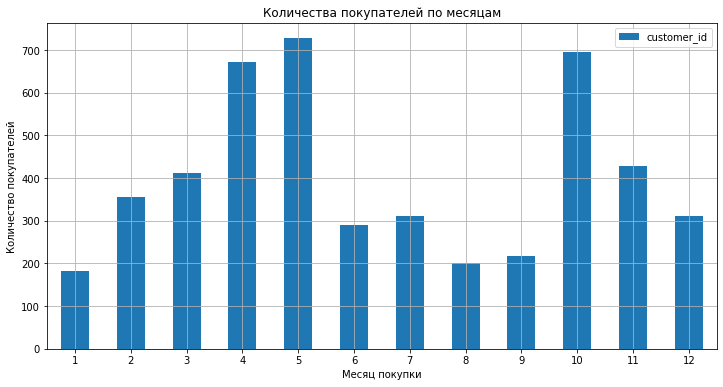

In [19]:
data_f.pivot_table(index='month',
                          values='customer_id',
                          aggfunc='count').plot(grid=True,
                                                kind='bar',
                                                figsize=(12,6))
plt.xlabel('Месяц покупки')
plt.ylabel('Количество покупателей')
plt.xticks(rotation=0)
plt.title('Количества покупателей по месяцам')
plt.show()

### 4,5 и 10 месяц у нас самые большие по колличеству клиентов

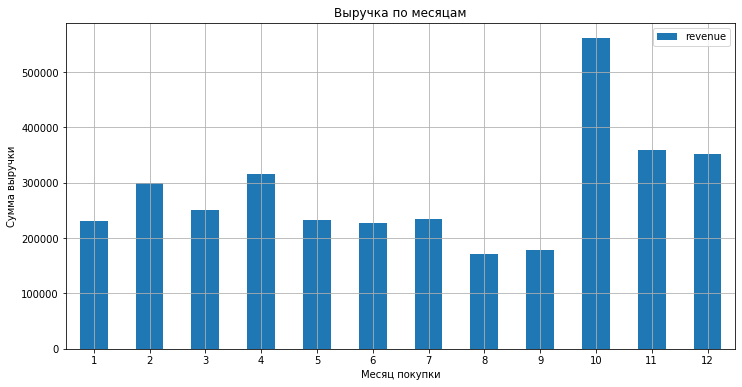

In [20]:
data_f.query("revenue < 600000").pivot_table(index='month',
                          values='revenue',
                          aggfunc='sum').plot(grid=True,
                                              kind='bar',
                                              figsize=(12,6))
plt.xlabel('Месяц покупки')
plt.ylabel('Сумма выручки')
plt.title('График выручки')
plt.xticks(rotation=0)
plt.title('Выручка по месяцам')
plt.show()

#### 10 месяц самый удачный, далее идет 11 и 12 месяц, остальные находятся примерно на одном уровне

### Поcмотрим на суммы выручки по дням недели и часам: <a id="step7"></a>

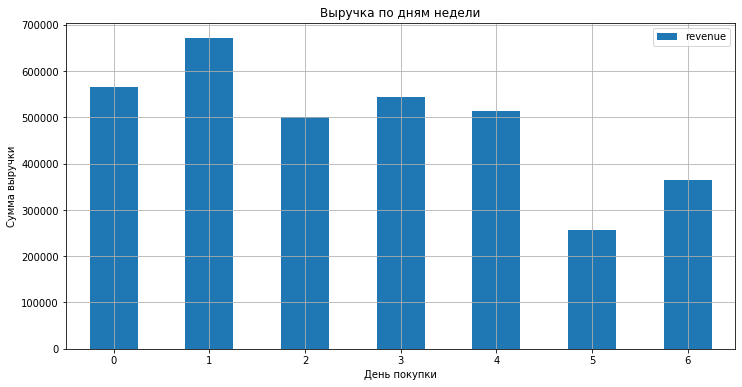

In [21]:
data_f.query("revenue < 600000").groupby('day').agg({'revenue':'sum'}).plot(grid=True,
                                                  kind='bar',
                                                  figsize=(12,6))
plt.xlabel('День покупки')
plt.ylabel('Сумма выручки')
plt.xticks(rotation=0)
plt.title('Выручка по дням недели')
plt.show()

#### Вторник - самый кассовый день, а вот суббота - наоборот ...остальные дни примерно одинаковые

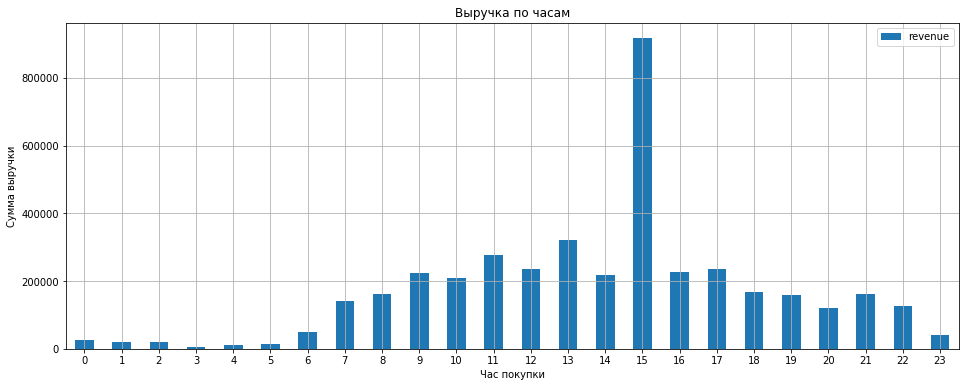

In [22]:
data_f.groupby('time').agg({'revenue':'sum'}).plot(grid=True,
                                                   kind='bar',
                                                   figsize=(16,6))
plt.xlabel('Час покупки')
plt.ylabel('Сумма выручки')
plt.xticks(rotation=0)
plt.title('Выручка по часам')
plt.show()

#### Ночью у нас почти не покупают, а вот с 7 утра начинается торговля, но самый прибыльным часом является 15 часов

### Имеется крупный оптовый заказ, как раз сделанный в 15:00, который искажает нам картину, также пересмотрел предыдущие графики

In [23]:
data_f.query("revenue > 600000")

,date,customer_id,order_id,product,quantity,price,last_order_date,month,week,data,day,time,revenue
3786,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,2019-06-18 15:00:00,6,25,2019-06-18,1,15,675000.0


In [24]:
### Сделаем график без учета этого заказа

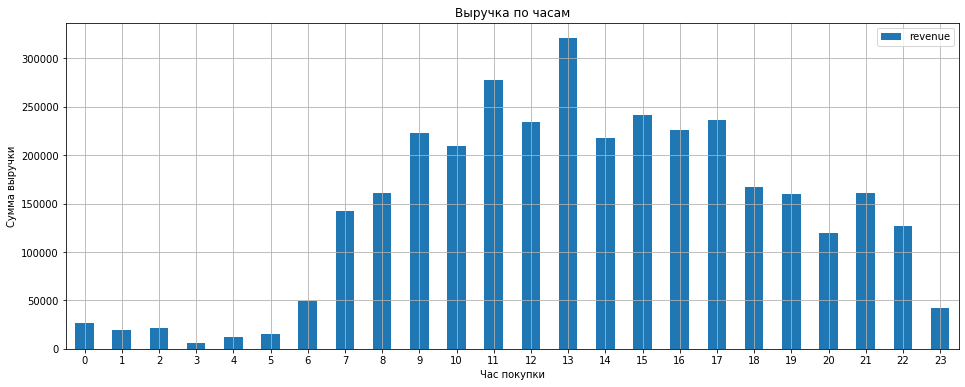

In [25]:
data_f.query("revenue < 600000").groupby('time').agg({'revenue':'sum'}).plot(grid=True,
                                                   kind='bar',
                                                   figsize=(16,6))
plt.xlabel('Час покупки')
plt.ylabel('Сумма выручки')
plt.xticks(rotation=0)
plt.title('Выручка по часам')
plt.show()

#### Ночью у нас почти не покупают, а вот с 7 утра до 21 вечера идет самая оживленная торговля

### Посчитаем среднее кол-во покупателей в месяц, неделю, день<a id="step8"></a>


In [26]:
# посчитаем среднее кол-во покупателей
mau = data_f.groupby('month').agg({'customer_id': 'nunique'}).mean()
wau = data_f.groupby('week').agg({'customer_id': 'nunique'}).mean()
dau = data_f.groupby('data').agg({'customer_id': 'nunique'}).mean()

print('Среднее количество покупателей:')
print('- в месяц', int(mau))
print('- в неделю', int(wau))
print('- в день', int(dau))

Среднее количество покупателей:
- в месяц 205
- в неделю 48
- в день 6


### Посчитаем среднее количество заказов в день <a id="step9"></a>

In [27]:
### Напишем функции, которая строит график, исключая выбросы
def vybros(df, column,graphic=0,x=10,y=10):
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    filt = (df[column] >= (q1 - 1.5*iqr)) & (df[column] <= (q3 + 1.5*iqr))
    if graphic == 1:
        return df.loc[filt].boxplot([column], figsize=(x,y))
    else:
        return df.loc[filt]

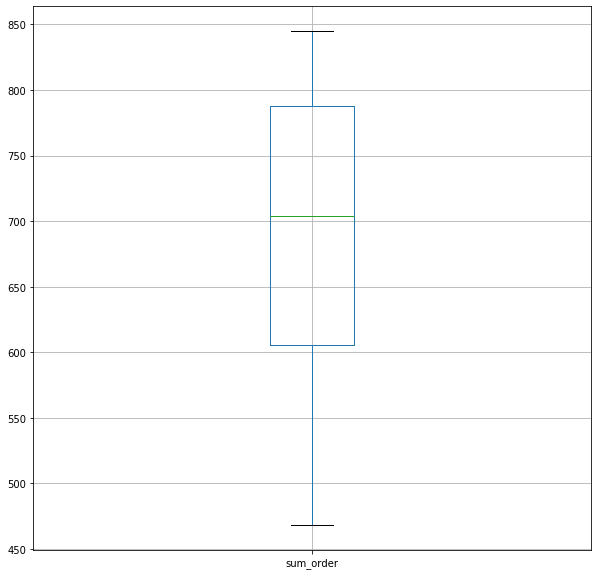

In [28]:
order = data_f.groupby('day').agg({'order_id': ['count']})
order.columns = ['sum_order']
vybros(order,'sum_order',1,10,10)


#### В день делают от 610 до 780 заказов, в среднем - 705 заказов


### Посмотрим  на средний чек за все время <a id="step10"></a>

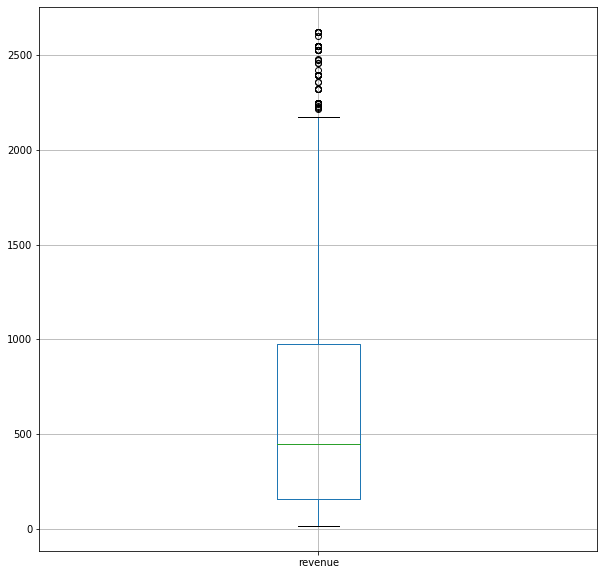

In [29]:
mean_cheсk = data_f.groupby('order_id').agg({'revenue':'mean'})
mean_cheсk['revenue'].mean().round(2)
vybros(mean_cheсk,'revenue',1,10,10)

#### Средний чек лежит в диапозоне от 200 до 950 у.е., средний значением является 450 у.е.

## Вывод по исследовательскому анализу <a id="step11"></a>
- 4,5 и 10 месяц у нас самые большие по колличеству клиентов
- 10 месяц самый удачный, далее идет 11 и 12 месяц, остальные находятся примерно на одном уровне- Понедельник - самый кассовый день, а вот суббота - наоборот ...остальные дни примерно одинаковые
- Ночью у нас почти не покупают, а вот с 7 утра до 21 вечера идет самая оживленная торговля
- Среднее количество покупателей:
    - в месяц 205
    - в неделю 48
    - в день 6
- В день делают от 640 до 825 заказов, в среднем - 725 заказов
- Средний чек лежит в диапозоне от 200 до 950 у.е., средний значением является 490 у.е.

Спасибо! Эти дубликаты проверил и исправил в предобработке данных)

In [30]:
data_f.groupby(['customer_id', 'order_id', 'product']).count().sort_values('date', ascending=False).head()

date  \
customer_id                          order_id product                                                    
000d6849-084e-4d9f-ac03-37174eaf60c4 14943    Пеларгония зональная диам. 12 см темнорозовая п...     1   
b19f6cb5-050c-4c18-bcb1-2204a1cc48c3 14722    Левкой рассада однолетних цветов в горшке диам....     1   
                                              Аргирантерум рассада однолетних цветов в горшке...     1   
                                              Алиссум рассада однолетних цветов в кассете по ...     1   
b18c373d-fcb4-4d14-8425-f26f21f52158 72275    Таз пластмассовый 30,0 л овальный ПЦ2913, 1404051      1   

                                                                                                  quantity  \
customer_id                          order_id product                                                        
000d6849-084e-4d9f-ac03-37174eaf60c4 14943    Пеларгония зональная диам. 12 см темнорозовая п...         1   
b19f6cb5-050c-4c18-bcb1-2204a1cc48c3 14722    Левкой рассада однолетних цветов в горшке диам....         1   
                                              Аргирантерум рассада однолетних цветов в горшке...         1   
                                              Алиссум рассада однолетних цветов в кассете по ...         1   
b18c373d-fcb4-4d14-8425-f26f21f52158 72275    Таз пластмассовый 30,0 л овальный ПЦ2913, 1404051          1   

                                                                                                  price  \
customer_id                          order_id product                                                     
000d6849-084e-4d9f-ac03-37174eaf60c4 14943    Пеларгония зональная диам. 12 см темнорозовая п...      1   
b19f6cb5-050c-4c18-bcb1-2204a1cc48c3 14722    Левкой рассада однолетних цветов в горшке диам....      1   
                                              Аргирантерум рассада однолетних цветов в горшке...      1   
                                              Алиссум рассада однолетних цветов в кассете по ...      1   
b18c373d-fcb4-4d14-8425-f26f21f52158 72275    Таз пластмассовый 30,0 л овальный ПЦ2913, 1404051       1   

                                                                                                  last_order_date  \
customer_id                          order_id product                                                               
000d6849-084e-4d9f-ac03-37174eaf60c4 14943    Пеларгония зональная диам. 12 см темнорозовая п...                1   
b19f6cb5-050c-4c18-bcb1-2204a1cc48c3 14722    Левкой рассада однолетних цветов в горшке диам....                1   
                                              Аргирантерум рассада однолетних цветов в горшке...                1   
                                              Алиссум рассада однолетних цветов в кассете по ...                1   
b18c373d-fcb4-4d14-8425-f26f21f52158 72275    Таз пластмассовый 30,0 л овальный ПЦ2913, 1404051                 1   

                                                                                                  month  \
customer_id                          order_id product                                                     
000d6849-084e-4d9f-ac03-37174eaf60c4 14943    Пеларгония зональная диам. 12 см темнорозовая п...      1   
b19f6cb5-050c-4c18-bcb1-2204a1cc48c3 14722    Левкой рассада однолетних цветов в горшке диам....      1   
                                              Аргирантерум рассада однолетних цветов в горшке...      1   
                                              Алиссум рассада однолетних цветов в кассете по ...      1   
b18c373d-fcb4-4d14-8425-f26f21f52158 72275    Таз пластмассовый 30,0 л овальный ПЦ2913, 1404051       1   

                                                                                                  week  \
customer_id                          order_id product                                                    
000d6849-084e-4d9f-ac03-37174eaf60c4 14943    Пеларг

## Категоризация товаров <a id="step12"></a>

### Определим топ-товары по выручке <a id="step13"></a>

In [31]:
top_product = data_f.pivot_table(index=['product'], values=['revenue',
                                                            'price',
                                                            'quantity'],
                                                            
                    aggfunc={'revenue': 'sum', 
                             'price': 'mean', 
                             'quantity': 'sum',
                             }).round().sort_values(by = 'revenue',
                                                    ascending = False)
top_product = top_product.reset_index()
top_product

,product,price,quantity,revenue
0,"Вантуз с деревянной ручкой d14 см красный, Bur...",675.0,1000,675000.0
1,Простынь вафельная 200х180 см WELLNESS RW180-0...,1852.0,30,53232.0
2,Сумка-тележка 2-х колесная Gimi Argo синяя,1072.0,47,50405.0
3,Вешалки мягкие для деликатных вещей 3 шт шоколад,156.0,335,49596.0
4,Тележка багажная DELTA ТБР-22 синий грузоподъе...,616.0,59,33992.0
...,...,...,...,...
2332,"Незабудка смесь 0,1 г 4650091480340",10.0,1,10.0
2333,"Цинния Оранжевый король 0,5 г 4660010770520",10.0,1,10.0
2334,Морковь Детская сладость 2 г 4660010775921,10.0,1,10.0
2335,"Горох Амброзия 10,0 г 4660010772616",9.0,1,9.0


### Выделим первое слово в названии товара

In [32]:
data_f['word'] = data_f['product'].apply(lambda x: x.split(' ')[0])

### Выделим топ 50 упоминаний товара <a id="step14"></a>

In [33]:
word = data_f.pivot_table(
    index ='word', 
    values = 'product', 
    aggfunc='count').sort_values(by = 'product',
                                 ascending = False)
word_top = word.head(100)

In [34]:
word = data_f['word'].value_counts().head(50)
word

Пеларгония       705
Рассада          465
Сушилка          272
Сумка-тележка    233
Муляж            169
томата           142
Петуния          140
Гладильная       117
Герань           110
Коврик           105
Тележка           97
Чехол             89
Штора             76
Таз               68
Однолетнее        65
Роза              57
Искусственный     52
Калибрахоа        50
Тарелка           39
Набор             38
Бакопа            37
Вешалка           36
Цветок            35
Корзина           33
Скатерть          31
Стремянка         26
Салатник          23
Полки             21
Подвесное         21
Мята              20
Чайник            19
Базилик           19
Фуксия            19
Банка             17
Флокс             16
Декабрист         16
Ёрш               15
Примула           15
Щетка             15
Вербена           15
Нож               14
Эвкалипт          14
Карниз            14
Фиалка            14
Дыня              14
Лобелия           14
Контейнер         14
Кружка       

### Вручеую выделим категории товара

In [35]:
word_top.index

Index(['Пеларгония', 'Рассада', 'Сушилка', 'Сумка-тележка', 'Муляж', 'томата',
       'Петуния', 'Гладильная', 'Герань', 'Коврик', 'Тележка', 'Чехол',
       'Штора', 'Таз', 'Однолетнее', 'Роза', 'Искусственный', 'Калибрахоа',
       'Тарелка', 'Набор', 'Бакопа', 'Вешалка', 'Цветок', 'Корзина',
       'Скатерть', 'Стремянка', 'Салатник', 'Подвесное', 'Полки', 'Мята',
       'Фуксия', 'Базилик', 'Чайник', 'Банка', 'Декабрист', 'Флокс', 'Вербена',
       'Ёрш', 'Примула', 'Щетка', 'Лобелия', 'Эвкалипт', 'Контейнер', 'Фиалка',
       'Нож', 'Карниз', 'Дыня', 'Кружка', 'Искусственная', 'Сумка', 'Швабра',
       'Подкладка', 'Цикламен', 'Капуста', 'Салфетка', 'Комнатное',
       'Новогоднее', 'Бегония', 'Пуансеттия', 'Ведро', 'Подрукавник',
       'Газания', 'Лестница-стремянка', 'Бальзамин', 'Циперус', 'Колокольчик',
       'Ложка', 'Антуриум', 'Арбуз', 'Декоративная', 'Сиденье', 'Перчатки',
       'Окномойка', 'Кувшин', 'Щетка-сметка', 'Штанга', 'Тимьян', 'Сковорода',
       'Виола', 'Тер

In [36]:
# Растения

plants = ['Пеларгония','Рассада','томата','Пеларгония', 'Роза','Петуния','Герань', 'Цветок','Однолетнее','Флокс','Цикламен','Примула'
        'Калибрахоа','Фуксия','Вербена','Пуансеттия','Фиалка','Дыня','Комнатное','Базилик','Бегония','Бальзамин','Бакопа'
         'Космея','Мята','Антуриум','Огурец','Хризантема','Эвкалипт','Декабрист','Томат','Гвоздика','Арбуз','Петрушка',
         'Цинния', 'Патиссон','Алиссум','Азалия','Тимьян']

# хозтовары

hoz = ['Сушилка','Чехол','Набор','Тележка','Таз','Тарелка','Вешалка','Вешалки','Скатерть','Корзина','Стремянка','Чайник','Салатник','Кружка',
      'Банка','Швабра','Нож','Лестница-стремянка','Ведро','Салфетка','Сковорода','Крючок','Ёрш','Перчатки','Средство',
      'Кастрюля','Ложка','Кофр','Комплект','Весы','Насадка','Вилка','Термокружка', 'Термос','Махровое',
       'Жестяная', 'Зубная', 'Шнур', 'Петля', 'Лоток','Ящик', 'Стакан', 'Коробка', 'Сиденье']

# интерьер 

inter = ['Муляж','Штора','Полки','Карниз','Ковер','Декоративная','Подарочный','Чайный','Новогоднее','Плед','Этажерка']

# Сумки

bags = ['Сумка-тележка']

In [37]:
# присваиваем каждому товару свою категорию
data_f['category'] = 'другое'
data_f.loc[data_f.query('word == @plants').index, 'category'] = 'растения'
data_f.loc[data_f.query('word == @hoz').index, 'category'] = 'хозтовары'
data_f.loc[data_f.query('word == @inter').index, 'category'] = 'товары для дома'
data_f.loc[data_f.query('word == @bags').index, 'category'] = 'сумки'

In [38]:
data_f.head()

,date,customer_id,order_id,product,quantity,price,last_order_date,month,week,data,day,time,revenue,word,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,10,40,2018-10-01,0,0,142.0,Комнатное,растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10-01,10,40,2018-10-01,0,0,194.0,Комнатное,растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01,10,40,2018-10-01,0,0,112.0,Радермахера,другое
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01,10,40,2018-10-01,0,0,179.0,Хризолидокарпус,другое
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01,10,40,2018-10-01,0,0,112.0,Циперус,другое


### Посмотрим на распределение выручки по категориям <a id="step15"></a>

In [39]:
count_c = data_f.groupby('category').agg({'category': 'count',
                                         'revenue':'sum'})
count_c

,category,revenue
category,,
другое,1223,1741909.0
растения,1999,354397.0
сумки,233,598127.0
товары для дома,327,295961.0
хозтовары,1022,1102191.0


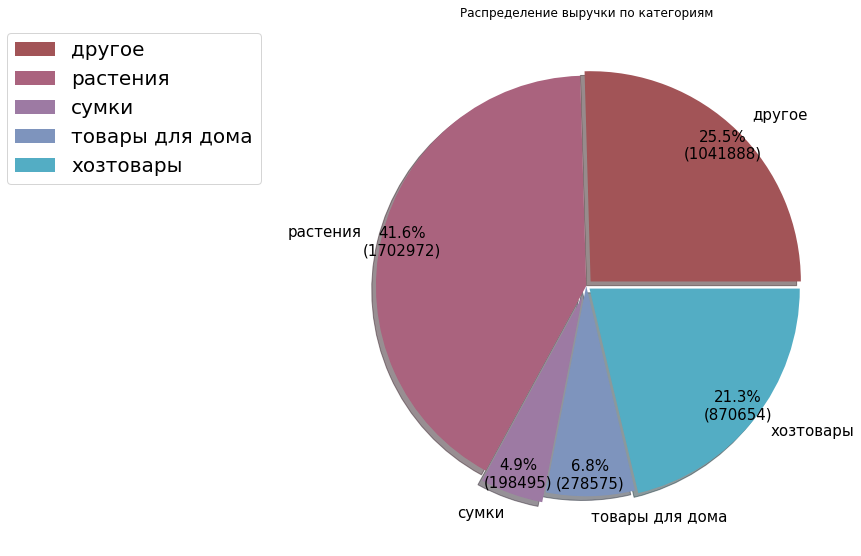

In [40]:
summary = count_c['revenue'].sum()
def func_pct(pct):
    value = float(pct/100.*summary)
    return "{:.1f}%\n({:.0f})".format(pct, value)

explode = (0.03,
           0,
           0.05,
           0,
           0.02)
# Оформим график

ax_pie = count_c.plot(kind='pie',
                               y='category',
                               use_index=False,
                               shadow=True,
                               explode=explode,
                               title = 'Распределение выручки по категориям',  
                               fontsize=15,
                               pctdistance=0.9,
                               figsize=(8,8), 
                               autopct=lambda pct: func_pct(pct),
                               colors=['#A25457',
                                       '#AA637E',
                                       '#9D7AA3',
                                       '#7E94BD',
                                       '#53ADC4',
                                       ])
                                      #labels=None)

plt.tight_layout(pad=0)

legend = ax_pie.legend(bbox_to_anchor=(-0.1,1), 
                       prop={'size':20})

y_label = ax_pie.set_ylabel('')

#### Почти 90% Выручки приходится на категории: растение, другое, хозтовары

### Посмотрим на сезонность по категориям <a id="step16"></a>

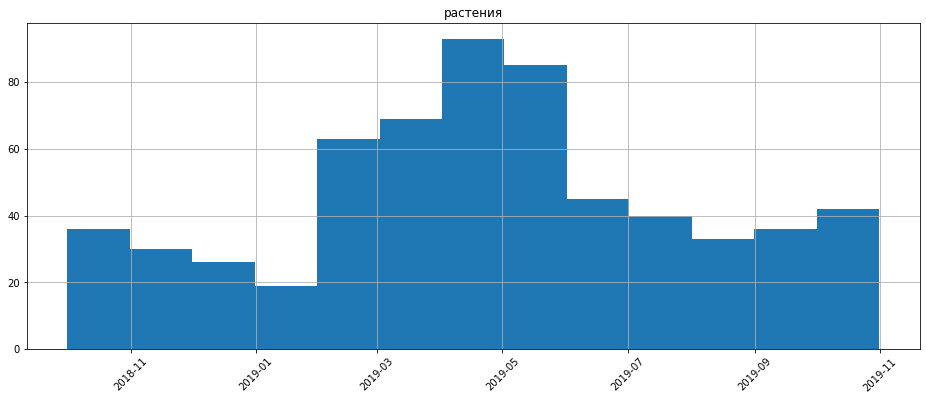

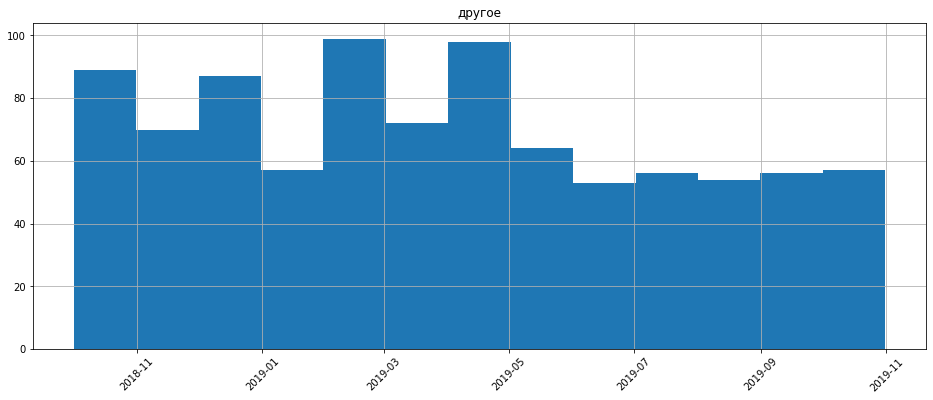

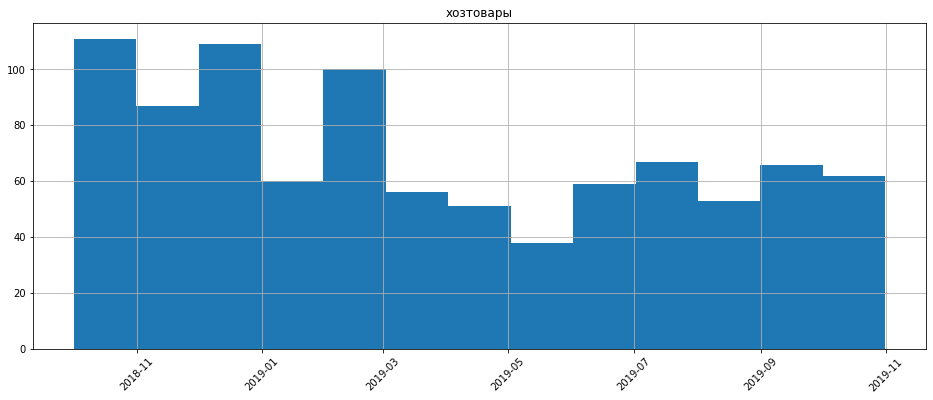

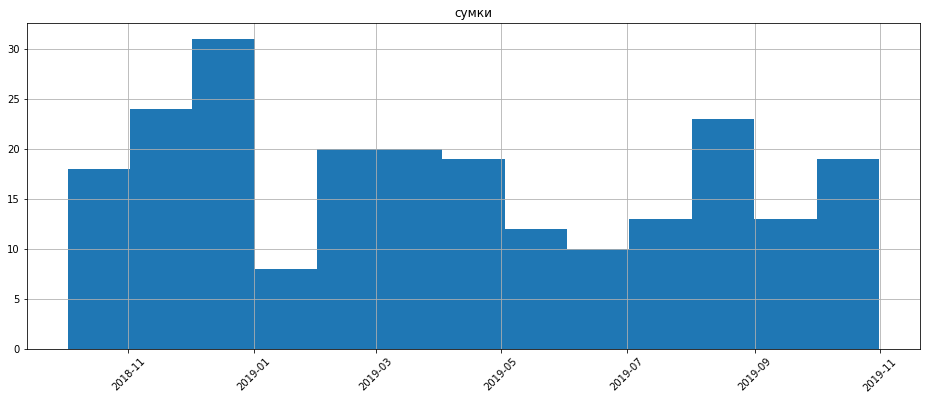

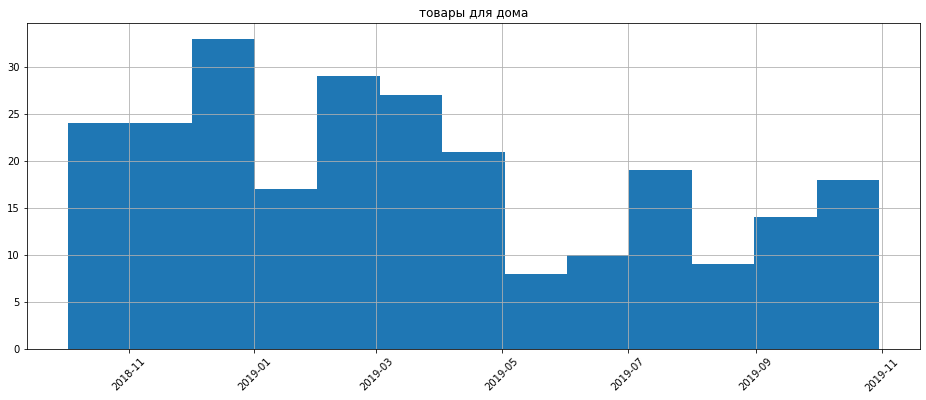

In [41]:
for product_group in  data_f['category'].unique():
    plt.figure(figsize=(16,6))
    data_f[data_f['category']==product_group].groupby('order_id').agg({'date':'min'})['date'].hist(bins=13)
    plt.title(product_group)
    plt.xticks(rotation=45)
    plt.show()

### Вывод по сезонности категорий <a id="step17"></a>
- Очевидно прослеживается снижение спроса на все товары в январе
- Пик спроса:
   - на растения пик спроса весной, очвеидно что люди покупают рассаду
   - в целом на зозтовары спрос довольно стабильный
   - на сумки пик спроса на конец 2018 и 2019 года
   - пик спроса на товары из группы интерьер наблюдается на конец 2018 года

## Итоги категоризации <a id="step18"></a>
- При помощи выделения первого слова из названия товара и составление ручного списка товаров, был применен цикл, который искал "Теги" в названии товара и присваивал ему категорию.
- Почти 90% Выручки приходится на категории: растение, другое, хозтовары
- Вывод по сезонности категорий
    - Очевидно прослеживается снижение спроса на все товары в январе
    - Пик спроса:
        - на растения пик спроса весной, очвеидно что люди покупают рассаду
        - в целом на зозтовары спрос довольно стабильный
        - на сумки пик спроса на конец 2018 и 2019 года
        - пик спроса на товары из группы интерьер наблюдается на конец 2018 года

## Кластеризация <a id="step19"></a>

### Для кластеризации оставим следующие признаки:<a id="step20"></a>
    - Средняя цена на товар
    - Среднее кол-во товара
    - Среднее количество товара в одном заказе
    - Сезон года
    - День недели

In [42]:
data_f.head()

,date,customer_id,order_id,product,quantity,price,last_order_date,month,week,data,day,time,revenue,word,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,10,40,2018-10-01,0,0,142.0,Комнатное,растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10-01,10,40,2018-10-01,0,0,194.0,Комнатное,растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01,10,40,2018-10-01,0,0,112.0,Радермахера,другое
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01,10,40,2018-10-01,0,0,179.0,Хризолидокарпус,другое
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01,10,40,2018-10-01,0,0,112.0,Циперус,другое


In [43]:
data_f['year'] = data_f['date'].dt.year

# cреднее цена
ml = data_f.groupby('product', as_index=False).agg({'price':'mean', 'quantity':'sum'})
ml.columns = ['product', 'price', 'quantity']

# cреднее количество в одном заказе
temp = data_f.groupby(['order_id', 'product'], as_index=False).agg({'quantity':'mean'})
temp = temp.groupby('product', as_index=False).agg({'quantity':'mean'}).round(2)
ml = pd.merge(ml, temp, on='product')
ml.columns = ['product', 'price', 'quantity', 'mean_quantity']
ml['mean_quantity'] = ml['mean_quantity'].astype('int')
ml.head()

,product,price,quantity,mean_quantity
0,Tepмокружка AVEX Freeflow 700 мл зеленый AVEX0759,2399.0,1,1
1,Tepмокружка AVEX Freeflow 700 мл сталь AVEX0776,2399.0,1,1
2,Tepмокружка AVEX Recharge 500 мл голубой AVEX0681,2099.0,2,1
3,Ёрш бутылочный с металлической ручкой малый Y6...,22.0,10,10
4,Ёрш для бутылки из натурального волокна и мета...,142.0,10,10


In [44]:
temp = data_f[(data_f['year']!=2019)|(data_f['month']!=10)]

In [45]:
temp = pd.pivot_table(temp, columns='day', values='quantity', index='product', aggfunc='sum').reset_index()
temp.columns = ['product', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
temp['sum'] = temp.iloc[:,1:9].sum(axis=1)
temp['monday'] = temp['monday']/temp['sum']
temp['tuesday'] = temp['tuesday']/temp['sum']
temp['wednesday'] = temp['wednesday']/temp['sum']
temp['thursday'] = temp['thursday']/temp['sum']
temp['friday'] = temp['friday']/temp['sum']
temp['saturday'] = temp['saturday']/temp['sum']
temp['sunday'] = temp['sunday']/temp['sum']
del temp['sum']
temp = temp.fillna(0)
ml = pd.merge(ml, temp, on='product', how='left')

In [46]:
temp = data_f[(data_f['year']!=2019)|(data_f['month']!=10)] 
temp['season'] = temp['month'].map({12:'winter', 1:'winter',2:'winter',
                   3:'spring',4:'spring',5:'spring',
                   6:'summer',7:'summer',8:'summer',
                   9:'autumn',10:'autumn', 11:'autumn'})
temp['season'].value_counts()

spring    1812
autumn    1128
winter     850
summer     800
Name: season, dtype: int64

In [47]:
temp = pd.pivot_table(temp, columns='season', values='quantity', index='product', aggfunc='sum').reset_index()
temp['sum'] = temp.iloc[:,1:6].sum(axis=1)
temp['autumn'] = temp['autumn']/temp['sum']
temp['spring'] = temp['spring']/temp['sum']
temp['summer'] = temp['summer']/temp['sum']
temp['winter'] = temp['winter']/temp['sum']
del temp['sum']
temp = temp.fillna(0)
ml = pd.merge(ml, temp, on='product', how='left')

### Матрица корреляций <a id="step21"></a>

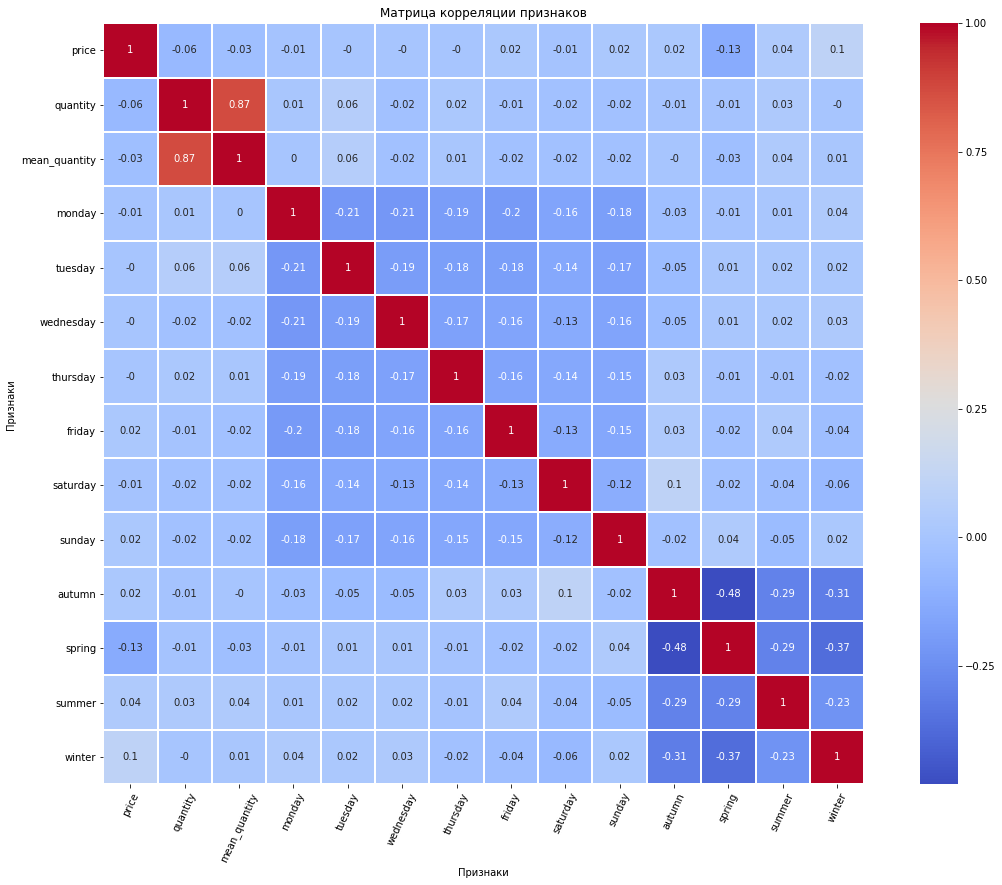

In [48]:
X = ml.drop('product', axis=1)
X = X.dropna()

# стандартизируем данные
scaler = StandardScaler()
x_sc = scaler.fit_transform(X)

#Матрица признаков корреляции
plt.figure(figsize=(20, 14))
sns.heatmap(X.corr().round(2), annot = True, square=True, linewidths=1,cmap = 'coolwarm') 
plt.xlabel('Признаки')
plt.ylabel('Признаки ')
plt.title('Матрица корреляции признаков')
plt.xticks(rotation=65)
plt.show()

#### Кроме quantity и mean_quantity_in_order признаки слабо коррелируют между собой

### Дендограмма <a id="step22"></a>

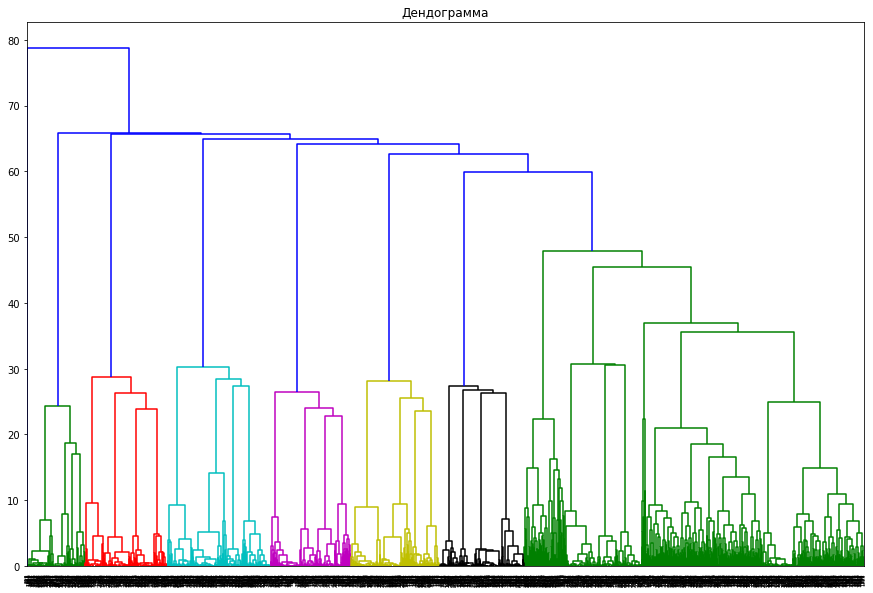

In [49]:
linked = linkage(x_sc, method = 'ward')
linked.shape

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендограмма')
plt.show()

### На дендограмме видим 7 групп. Зададим модель k_means

In [50]:
ml = ml.dropna()
km = KMeans(n_clusters = 7, random_state=0)
labels = km.fit_predict(x_sc)
ml['clusters'] = labels

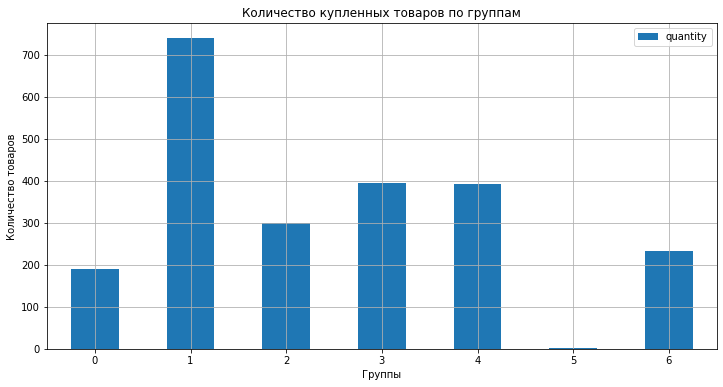

In [51]:
ml.groupby('clusters').agg({'quantity':'count'}).plot(grid=True, kind='bar', figsize=(12,6))
plt.xlabel('Группы')
plt.ylabel('Количество товаров')
plt.xticks(rotation=0)
plt.title('Количество купленных товаров по группам')
plt.show()

In [52]:
group = ml.drop(['product'], axis=1).groupby('clusters').mean().reset_index()
group

,clusters,price,quantity,mean_quantity,monday,tuesday,wednesday,thursday,friday,saturday,sunday,autumn,spring,summer,winter
0,0,562.265677,3.473684,2.036842,0.018463,0.010729,0.007453,0.013000,0.011683,0.914454,0.024218,0.475341,0.263802,0.120858,0.139999
1,1,624.103103,7.104195,2.803789,0.050674,0.040529,0.047642,0.408448,0.388792,0.025392,0.038523,0.312660,0.341790,0.182166,0.163384
2,2,648.149705,3.943144,2.588629,0.014522,0.013573,0.913432,0.014945,0.007907,0.018893,0.016729,0.232062,0.339688,0.183544,0.244707
3,3,610.579420,5.665823,3.281013,0.045947,0.829350,0.032352,0.021768,0.017051,0.025867,0.027665,0.237561,0.366943,0.181398,0.214098
4,4,595.432857,5.362245,3.533163,0.899749,0.014085,0.020700,0.023736,0.009258,0.014585,0.017887,0.252487,0.313458,0.178171,0.255884
5,5,675.000000,1000.000000,1000.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
6,6,657.366667,2.745690,1.883621,0.016308,0.008385,0.012128,0.011824,0.013013,0.011546,0.926796,0.251829,0.401998,0.111806,0.234367


## Вывод по кластеризации <a id="step23"></a>
### В итоге кластеризации у нас образовалась 7 групп покупателей, каждой из которых соответсвует определенное поведение<a id="step25"></a>
- Группа 0. 250 позиций, заказы в основном по субботам, осенью и весной
- Группа 1. 750 позиций, заказы в онсновном по четвергам, пятницам и субботам, осенью и весной
- Группа 2. 300 позиций. 90% заказов по средам, меньше всего заказов летом
- Группа 3. 395 позиций. 80% заказов по вторникам, спрос в течении года примерно одинаковый, но выделяется осень - 36%
- Группа 4. 390 позиций, 89% заказов по понедельникам, спрос в течении года примерно одинаковый
- Группа 5. 1 позиция, оптовая закупка вантузами)
- Группа 6. 230 позиций, 92% заказов в воскресенье, чаще всего покупают весной

## Проверка гипотез<a id="step24"></a>

### Влияет ли количество товаров в чеке на выручку?


### Подготовим данные

In [53]:
q_per_order = data_f.groupby(['order_id', 'category']).agg({'quantity':'sum'}).reset_index()
quantity = q_per_order.groupby('order_id')['quantity'].sum()
quantity.name = 'total'

q_per_order = q_per_order.join(quantity, on='order_id')
q_per_order.head()

,order_id,category,quantity,total
0,12624,другое,2,2
1,13547,растения,3,3
2,14480,другое,1,3
3,14480,растения,2,3
4,14481,растения,4,4


### Cоздадим списки заказов с 1 товаром и более 1 товара

In [54]:
# с 1 товаром
orders_1 = q_per_order[q_per_order['total'] == 1]['order_id'].to_list()
# более чем 1 товаром
orders_2 = q_per_order[q_per_order['total'] > 1]['order_id'].to_list()

### Cоздадим списки стоимости заказов с 1 товаром и более 1 товара

In [55]:
# список стоимости заказов с 1 товаром
sample_1 = data_f.query('order_id in @orders_2').groupby('order_id')['revenue'].sum()
# список стоимости заказов с более чем 1 товаром
sample_2 = data_f.query('order_id in @orders_1').groupby('order_id')['revenue'].sum()

### Сформулируем гипотезы
    - Нулевая гипотеза: количество товаров в чеке не влияет на выручку
    - Альетрнативная гипотеза: количество товаров в чеке влияет на выручку

### Проведем тест

In [56]:
alpha = .05

results = st.ttest_ind(sample_1, sample_2)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.02471669405307402
Отвергаем нулевую гипотезу


#### Результаты тесты говорят нам о том, что количество товаров в чеке вляет на выручку . Это говорит о том, что люди чаще покупают больше одного товара по не большой цене, чем один товар с высокой ценой

## Количество проданного товара в выходные и будни дни одинаковое?

### Подготовим данные

In [57]:
sample1 = data_f.query('day > 4')['quantity']
sample2 = data_f.query('day < 5')['quantity']

### Сформулируем гипотезы
     - Нулевая гипотеза: количество проданного товара в выходные и будни дни не одинаковые.
     - Альтернативная гипотеза: количество проданного товара в выходные и будни дни одинаковое одинаковые.

In [58]:
alpha = 0.5

results = st.ttest_ind(sample1, sample2)
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.05637244190017963
Отвергаем нулевую гипотезу


#### Результаты тесты говорят нам о том, что количество товаров проданных в выходные и будни товаров дни примерно равны.

## Итоги по проверке гипотез 
- Мною были выдвинуты две гипотезы:
    - Влияет ли количество товаров в чеке на выручку?
    - Количество проданного товара в выходные и будни дни одинаковое?
- Результаты теста: 
    - Количество товаров в чеке вляет на выручку в чеке
    - Количество товаров проданных в выходные и будни товаров  примерно равны

## Общий вывод <a id="step26"></a>

- 4,5 и 6 месяц у нас самые большие по колличеству клиентов
- 6 месяц самый удачныйпо выручке, далее идет 10 месяц, остальные находятся примерно на одном уровне
- Понедельник - самый кассовый день, а вот суббота - наоборот ...остальные дни примерно одинаковые
- Ночью у нас почти не покупают, а вот с 7 утра начинается торговля, но самый прибыльным часом является 15 часов
- Среднее количество покупателей:
    - в месяц 205
    - в неделю 48
    - в день 6
- В день делают от 640 до 825 заказов, в среднем - 725 заказов
- Средний чек лежит в диапозоне от 200 до 950 у.е., средний значением является 490 у.е.
- Почти 90% Выручки приходится на категории: растение, другое, хозтовары
    - Вывод по сезонности категорий:
        - Очевидно прослеживается снижение спроса на все товары в январе
        - Пик спроса:
            - на растения пик спроса весной, очвеидно что люди покупают рассаду
            - в целом на зозтовары спрос довольно стабильный
            - на сумки пик спроса на конец 2018 и 2019 года
            - пик спроса на товары из группы интерьер наблюдается на конец 2018 года
- Была проведена кластеразицация пользователей на [группы](#step25)
- Проверка гипотез дала нам следующие результаты:
    - Количество товаров в чеке вляет на выручку в чеке
    - Количество товаров проданных в выходные и будни товаров  примерно равны


## Баг
При проверке для каждого заказа уникального клиента обнаружилось, что на один заказ иногда приходится более 1 уникального клиента. Проведена очистка данных, потери в сравнении с изначальным датафреймом составила 0,1%